In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:38<00:00, 22.0MB/s]
100% 2.13G/2.13G [01:38<00:00, 23.1MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/leapgestrecog.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/leapgestrecog.zip' mode='r'>>

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import keras as keras
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

In [9]:
dir = '/content/leapGestRecog'

In [10]:
images = []
labels = []

for directory in os.listdir(dir):
  for subdir in os.listdir(os.path.join(dir, directory)):
    for img in os.listdir(os.path.join(dir, directory, subdir)):
      img_path = os.path.join(dir, directory, subdir, img)
      images.append(img_path)
      labels.append(subdir)

In [11]:
img_series = pd.Series(images, name='Images')
lab_series = pd.Series(labels, name='labels')

data = pd.concat([img_series, lab_series], axis = 1)
df = pd.DataFrame(data)
df.head()

,Images,labels
0,/content/leapGestRecog/06/10_down/frame_06_10_...,10_down
1,/content/leapGestRecog/06/10_down/frame_06_10_...,10_down
2,/content/leapGestRecog/06/10_down/frame_06_10_...,10_down
3,/content/leapGestRecog/06/10_down/frame_06_10_...,10_down
4,/content/leapGestRecog/06/10_down/frame_06_10_...,10_down


In [12]:
image_shape = cv2.imread('/content/leapGestRecog/04/05_thumb/frame_04_05_0003.png')
print(image_shape.shape)

(240, 640, 3)


In [13]:
pd.Series(labels).value_counts()

10_down          2000
09_c             2000
03_fist          2000
04_fist_moved    2000
02_l             2000
06_index         2000
01_palm          2000
05_thumb         2000
08_palm_moved    2000
07_ok            2000
Name: count, dtype: int64

In [14]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(df, test_size=0.3, random_state=42)

In [15]:
img_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = img_gen.flow_from_dataframe(dataframe= train_set,x_col="Images",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )

test = img_gen.flow_from_dataframe(dataframe= X_test,x_col="Images", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
valid = img_gen.flow_from_dataframe(dataframe= valid_set,x_col="Images", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [16]:
classes = list(train.class_indices.keys())
classes

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [17]:
input_shape = (244, 244, 3)
num_classes = 10

In [18]:
inputs = Input(shape=input_shape)

x = Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)

In [19]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 79, 79, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 79, 79, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 79, 79, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 79, 79, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 256)       0     

In [20]:
history = model.fit(train, epochs=3, validation_data=valid, verbose=1)

Epoch 1/3
3500/3500 [==============================] - 208s 57ms/step - loss: 0.5262 - accuracy: 0.8366 - val_loss: 0.0129 - val_accuracy: 0.9963
Epoch 2/3
3500/3500 [==============================] - 199s 57ms/step - loss: 0.0267 - accuracy: 0.9926 - val_loss: 7.5827e-04 - val_accuracy: 1.0000
Epoch 3/3
3500/3500 [==============================] - 199s 57ms/step - loss: 0.0088 - accuracy: 0.9980 - val_loss: 5.4697e-04 - val_accuracy: 1.0000


In [21]:
model.evaluate(test, verbose=1)

1000/1000 [==============================] - 19s 19ms/step - loss: 4.3865e-04 - accuracy: 1.0000


[0.00043865316547453403, 1.0]

In [22]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

1000/1000 [==============================] - 18s 18ms/step


In [26]:
from sklearn.metrics import classification_report, accuracy_score # Import accuracy_score

y_test = X_test.labels
print(classification_report(y_test, pred2)) # Now classification_report is available.
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       403
         02_l       1.00      1.00      1.00       377
      03_fist       1.00      1.00      1.00       404
04_fist_moved       1.00      1.00      1.00       418
     05_thumb       1.00      1.00      1.00       409
     06_index       1.00      1.00      1.00       392
        07_ok       1.00      1.00      1.00       366
08_palm_moved       1.00      1.00      1.00       410
         09_c       1.00      1.00      1.00       404
      10_down       1.00      1.00      1.00       417

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000

Accuracy of the Model: 100.0%


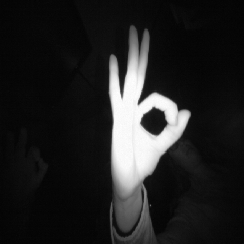

In [37]:
img1 = load_img("/content/leapGestRecog/00/07_ok/frame_00_07_0055.png",target_size=(244,244,3))
img1

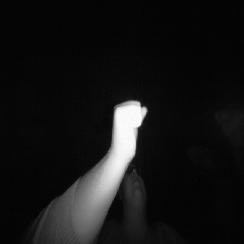

In [38]:
img2 = load_img("/content/leapGestRecog/05/04_fist_moved/frame_05_04_0004.png",target_size=(244,244,3))
img2

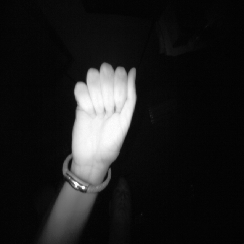

In [39]:
img3 = load_img("/content/leapGestRecog/08/03_fist/frame_08_03_0002.png",target_size=(244,244,3))
img3

In [40]:
img1 = img_to_array(img1)
img1 = img1 / 255.0
img1 = np.expand_dims(img1, axis=0)


img2 = img_to_array(img2)
img2 = img2 / 255.0
img2 = np.expand_dims(img2, axis=0)


img3 = img_to_array(img3)
img3 = img3 / 255.0
img3 = np.expand_dims(img3, axis=0)

p1 = model.predict(img1).argmax()
p2 = model.predict(img2).argmax()
p3 = model.predict(img3).argmax()

print("Class for Image 1:", p1)
print("Class for Image 2:", p2)
print("Class for Image 3:", p3)

1/1 [==============================] - 0s 31ms/step
Class for Image 1: 6
Class for Image 2: 6
Class for Image 3: 6
